# WP6
## Modified from John D'Angelo (jjd9 @ Github)
### Univeristy of Texas at Austin
### Fall 2018

#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
from scipy.optimize import curve_fit

## 1) Compressibility of mudrocks

In [2]:
#pull in file
filename = 'ShaleData.xlsx'
df = pd.read_excel(filename)
df.head()

,Shale Porosity,SubseaTVD(m)
0,0.370927,357.383235
1,0.355141,451.968183
2,0.353008,559.708342
3,0.350928,707.831940
4,0.332887,815.929023


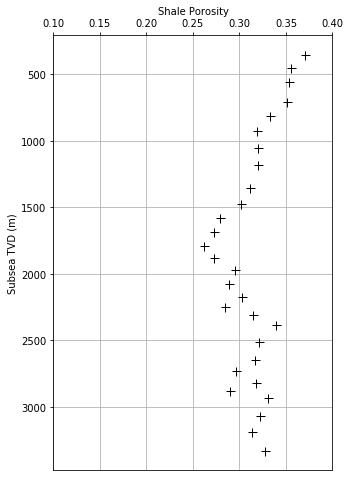

In [3]:
#Make sure data was digitized properly
fig,ax=plt.subplots(figsize=(5,8))
df.plot(x='Shale Porosity',y='SubseaTVD(m)',linestyle='',marker='+',markerSize=9,color='k',ax=ax,legend=False)
ax.xaxis.tick_top()
ax.set_xlabel('Shale Porosity')
ax.set_ylabel('Subsea TVD (m)')
ax.xaxis.set_label_position('top') 
ax.set_xlim([0.1,0.4])
ax.invert_yaxis()
ax.grid()

a) Compute and plot pore pressure assuming hydrostatic por pressure gradient dPp/dz = 0.465 psi/ft

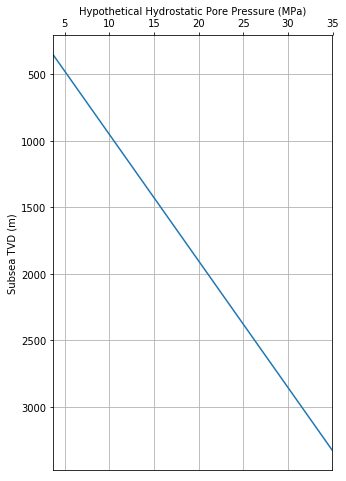

In [13]:
# I will work in SI units today
gradPp = 0.465 #psi/ft
gradPp *= 22620.6 #Pa/m
df['Hypothetical Hydrostatic Pore Pressure'] = gradPp*df['SubseaTVD(m)']/1e6 #MPa
fig,ax=plt.subplots(figsize=(5,8))
df.plot(x='Hypothetical Hydrostatic Pore Pressure',y='SubseaTVD(m)',ax=ax,legend=False)
ax.xaxis.tick_top()
ax.set_xlabel('Hypothetical Hydrostatic Pore Pressure (MPa)')
ax.set_ylabel('Subsea TVD (m)')
ax.xaxis.set_label_position('top') 
ax.invert_yaxis()
ax.grid()


b) Compute and plot total vertical stress assuming dSv/dz = 0.950 psi/ft and pick the seafloor from the shallowest data point in "percent sand" plot

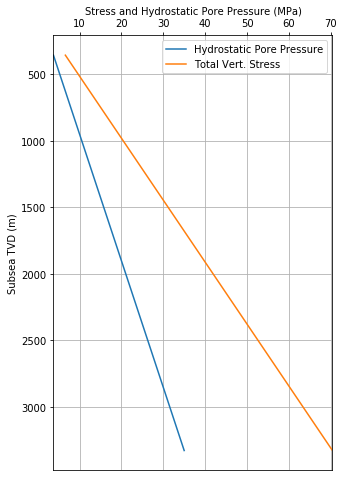

In [16]:
gradSv = 0.950 #psi/ft
gradSv *= 22620.6 #Pa/m

# I will pick the seafloor as 50 [m] since that appears to be the shallowed datapoint
# in the percent sand plot (not shown here)
seaFloor = 50

df['Total Vert. Stress'] = gradSv*(df['SubseaTVD(m)']-seaFloor)/1e6 #MPa

fig,ax=plt.subplots(figsize=(5,8))
df.plot(x='Pore Pressure',y='SubseaTVD(m)',ax=ax,label='Hydrostatic Pore Pressure')
df.plot(x='Total Vert. Stress',y='SubseaTVD(m)',ax=ax,label='Total Vert. Stress')

ax.xaxis.tick_top()
ax.set_xlabel('Stress and Hydrostatic Pore Pressure (MPa)')
ax.set_ylabel('Subsea TVD (m)')
ax.xaxis.set_label_position('top') 
ax.invert_yaxis()
ax.grid()

c) Digitize shale data and fit equation of porosity as a function of vertical effecitve stress from 400 m to 1800 m assuming hydrostatic pore pressure an exponential model on porosity and a logarithmic model on void ratio.

In [6]:
df['Eff. Vert. Stress'] = df['Total Vert. Stress'] - df['Pore Pressure'] #MPa
df['Void Ratio'] = df['Shale Porosity']/(1-df['Shale Porosity'])
select = (df['SubseaTVD(m)'] > 400) & (df['SubseaTVD(m)'] < 1800)
miniDF = df[select]

def fun_porosity(x,beta):
    #Exponential model on porosity
    phi0 = df['Shale Porosity'].iloc[0]
    return phi0*np.exp(-beta*x)

def fun_void(x,Cc):
    #Logarithmic model on void ratio
    phi0 = df['Shale Porosity'].iloc[0]
    e0 = phi0/(1-phi0)
    return e0 - Cc*np.log(x/1)


beta_opt, beta_cov = curve_fit(fun_porosity,miniDF['Eff. Vert. Stress'],miniDF['Shale Porosity'])
Cc_opt, Cc_cov = curve_fit(fun_void,miniDF['Eff. Vert. Stress'],miniDF['Void Ratio'])

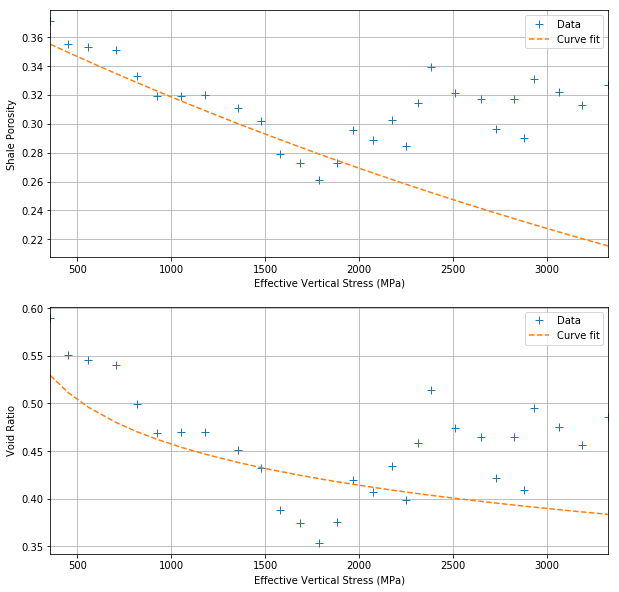

In [7]:
#Check the fit
df['Estimated Porosity'] = df['Shale Porosity'].iloc[0]*np.exp(-beta_opt*df['Eff. Vert. Stress'])
df['Estimated Void Ratio'] = df['Void Ratio'].iloc[0] - Cc_opt*np.log(df['Eff. Vert. Stress']/1)

fig,ax=plt.subplots(2,1,figsize=(10,10))
df.plot(y='Shale Porosity',x='SubseaTVD(m)',linestyle='',marker='+',markerSize=8,ax=ax[0],label='Data')
df.plot(y='Estimated Porosity',x='SubseaTVD(m)',linestyle='--',ax=ax[0],label='Curve fit')
df.plot(y='Void Ratio',x='SubseaTVD(m)',linestyle='',marker='+',markerSize=8,ax=ax[1],label='Data')
df.plot(y='Estimated Void Ratio',x='SubseaTVD(m)',linestyle='--',ax=ax[1],label='Curve fit')

ax[0].legend()
ax[0].set_ylabel('Shale Porosity')
ax[0].set_xlabel('Effective Vertical Stress (MPa)')
ax[0].grid()
ax[1].legend()
ax[1].set_ylabel('Shale Void Ratio')
ax[1].set_xlabel('Effective Vertical Stress (MPa)')
ax[1].grid()

d) Calculate and plot actual pore pressure between interval 1800 and 3400 m assuming porosity is a function of vertical effective stress with the models calculated in point c.

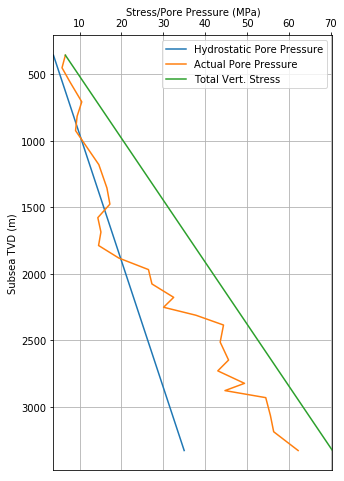

In [17]:
df['Actual Pore Pressure'] = df['Total Vert. Stress'] + np.log(df['Shale Porosity']/df['Shale Porosity'].iloc[0])/beta_opt
select = (df['SubseaTVD(m)'] > 1800) & (df['SubseaTVD(m)'] < 3400)
miniDF = df#[select]

fig,ax=plt.subplots(figsize=(5,8))
miniDF.plot(x='Pore Pressure',y='SubseaTVD(m)',ax=ax,label='Hydrostatic Pore Pressure')
miniDF.plot(x='Actual Pore Pressure',y='SubseaTVD(m)',ax=ax,label='Actual Pore Pressure')
miniDF.plot(x='Total Vert. Stress',y='SubseaTVD(m)',ax=ax,label='Total Vert. Stress')

ax.xaxis.tick_top()
ax.set_xlabel('Stress/Pore Pressure (MPa)')
ax.set_ylabel('Subsea TVD (m)')
ax.xaxis.set_label_position('top') 
ax.invert_yaxis()
ax.grid()

e) Calculate and plot overpressure parameter as a function of depth.

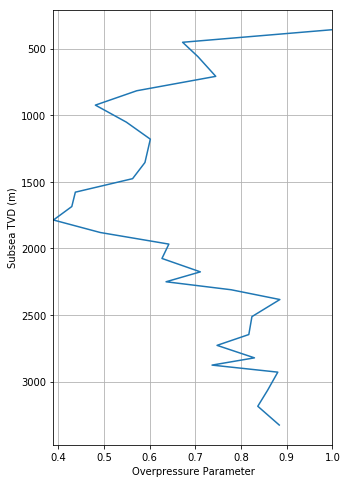

In [9]:
df['OP param'] = df['Actual Pore Pressure']/df['Total Vert. Stress']

fig,ax=plt.subplots(figsize=(5,8))

df.plot(x='OP param',y='SubseaTVD(m)',label='Overpressure Parameter',legend=False,ax=ax)
ax.set_xlabel('Overpressure Parameter')
ax.set_ylabel('Subsea TVD (m)')
ax.invert_yaxis()
ax.grid()

f) Summarize the results with plots

[]

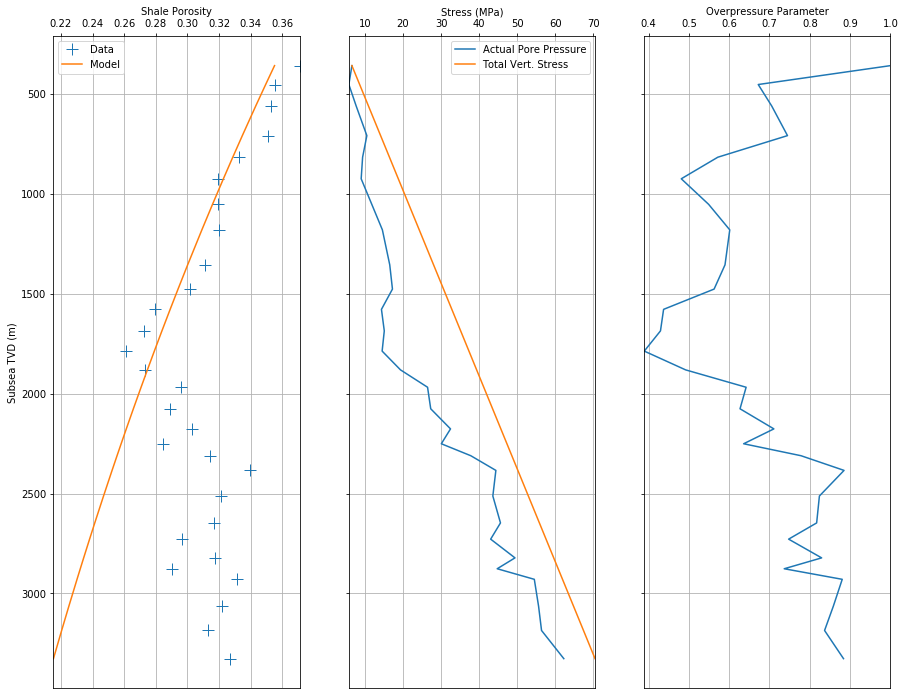

In [10]:
fig,ax = plt.subplots(1,3,figsize=(15,12))
#porosity (model and data) in log scale as function of depth on y-axis
df.plot(x='Shale Porosity',y='SubseaTVD(m)',linestyle='',marker='+',markerSize=12,ax=ax[0],label='Data')
df.plot(x='Estimated Porosity',y='SubseaTVD(m)',linestyle='-',ax=ax[0],label='Model')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Shale Porosity')
ax[0].xaxis.set_label_position('top') 
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel('Subsea TVD (m)')

# Sv and actual Pp as a function of depth y-axis
df.plot(x='Actual Pore Pressure',y='SubseaTVD(m)',ax=ax[1],label='Actual Pore Pressure')
df.plot(x='Total Vert. Stress',y='SubseaTVD(m)',ax=ax[1],label='Total Vert. Stress')
ax[1].xaxis.tick_top()
ax[1].set_xlabel('Stress (MPa)')
ax[1].xaxis.set_label_position('top') 
ax[1].invert_yaxis()
ax[1].grid()
ax[1].get_yaxis().set_ticklabels([])

#overpressure parameter as a function of depth y-axis
df.plot(x='OP param',y='SubseaTVD(m)',label='Overpressure Parameter',legend=False,ax=ax[2])
ax[2].set_xlabel('Overpressure Parameter')
ax[2].xaxis.tick_top()
ax[2].set_xlabel('Overpressure Parameter')
ax[2].xaxis.set_label_position('top') 
ax[2].invert_yaxis()
ax[2].grid()
ax[2].get_yaxis().set_ticklabels([])